# Experiment 2 of 3 - Weight-only 8-bit
## Cutting model weight memory in half
**Quantize attention/MLP weights to INT8 using bitsandbytes LLM.int8()**
### Expected outcome:

*   Little loss in accuracy
*   VRAM drops to approx. half



# Step 1: Installing Dataset
Installing and unzipping COCO dataset

In [1]:
# downloading zip files
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

--2025-11-11 13:09:56--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.178.31, 16.182.37.81, 16.15.180.194, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.178.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco_val2017.zip’

coco_val2017.zip    100%[===================>] 777.80M  61.2MB/s    in 13s     

2025-11-11 13:10:09 (58.5 MB/s) - ‘coco_val2017.zip’ saved [815585330/815585330]

--2025-11-11 13:10:09--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.211, 16.15.193.148, 3.5.28.63, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.211|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘coco_ann2017.zip’

coco_ann2017.zip    100%[=======

In [2]:
# unzipping dataset
from zipfile import ZipFile
import os

def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path + ".zip") as zfile:
            zfile.extractall(extract_path)
        # Remove the zip file after extraction
        os.remove(extract_path + ".zip")
    except Exception as e:
        print("Error:", e)

extract_zip_file("./coco_val2017")
extract_zip_file("./coco_ann2017")

# Step 2: Setting up LLM
Set up the LLaVA-1.5 (7B/13B variants) model in this Colab notebook, load the COCO dataset and annotations, and provide a simple use case demonstrating how to use the model with an image and a prompt.

## Step 2.a: Set up the environment

### Subtask:
Install necessary libraries and dependencies for LLaVA.


In [3]:
%pip install transformers[flash-attn,bitsandbytes] accelerate einops tqdm gradio

## Step 2.b: Prepare the data

### Subtask:
Load the COCO dataset and annotations.


In [4]:
import json

annotation_path = './coco_ann2017/annotations/instances_val2017.json'
with open(annotation_path, 'r') as f:
    coco_annotations = json.load(f)

image_directory = './coco_val2017/val2017'

print(f"Loaded annotations from: {annotation_path}")
print(f"Image directory set to: {image_directory}")

Loaded annotations from: ./coco_ann2017/annotations/instances_val2017.json
Image directory set to: ./coco_val2017/val2017


In [5]:
import json

# Define the correct paths to the annotation file and image directory
annotation_path = './coco_ann2017/annotations/instances_val2017.json'
image_directory = './coco_val2017/val2017'

# Load the JSON annotation file into a Python dictionary
with open(annotation_path, 'r') as f:
    coco_annotations = json.load(f)

# Store the loaded annotations in a variable (already done above)
# Confirm the image directory path is correctly set (print it)
print(f"Loaded annotations from: {annotation_path}")
print(f"Image directory set to: {image_directory}")

# Optionally, print some information about the loaded annotations to confirm
print(f"Number of images in annotations: {len(coco_annotations['images'])}")
print(f"Number of annotations: {len(coco_annotations['annotations'])}")

Loaded annotations from: ./coco_ann2017/annotations/instances_val2017.json
Image directory set to: ./coco_val2017/val2017
Number of images in annotations: 5000
Number of annotations: 36781


## Step 3: Initial Setup of LLM
Run LLM with Weight-only 8-bit

In [6]:
from PIL import Image
import random
import os
import torch
from transformers import LlavaForConditionalGeneration, AutoProcessor
torch.cuda.empty_cache()

In [7]:
%pip install pycocoevalcap

In [8]:
from pycocoevalcap.cider.cider import Cider
import json

# Load ground truth captions
captions_path = './coco_ann2017/annotations/captions_val2017.json'
with open(captions_path, 'r') as f:
    coco_captions = json.load(f)

# Create dictionaries for ground truth and generated captions
ground_truth_captions = {}
for ann in coco_captions['annotations']:
    image_id = ann['image_id']
    caption = ann['caption']
    if image_id not in ground_truth_captions:
        ground_truth_captions[image_id] = []
    ground_truth_captions[image_id].append(caption)

## Step 4: Change LLM to Weight-Only 8-bit

In [9]:
%pip install -U bitsandbytes

from transformers import LlavaForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
import torch

model_id = "llava-hf/llava-1.5-7b-hf"

# 8-bit quantization config for LLM layers
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.float16,
)


device_map = "auto"

# Load model with weight-only INT8 for LLM
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map=device_map,
    low_cpu_mem_usage=True,
)

# Keep vision tower in FP16
model.vision_tower = model.vision_tower.half()

# Processor for images/text
processor = AutoProcessor.from_pretrained(model_id)

print("LLaVA loaded successfully: LLM weight-only INT8, vision encoder FP16")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

LLaVA loaded successfully: LLM weight-only INT8, vision encoder FP16


In [10]:
import os
import time
import torch
from PIL import Image

# --- Setup ---
image_files = sorted( # sorted so that we avoid randomness
    [f for f in os.listdir(image_directory) if f.endswith('.jpg')]
)
if not image_files:
    raise FileNotFoundError(f"No JPG images found in the directory: {image_directory}")

prompt_text = "Generate a caption for this image"
prompt_template = "USER: <image>\n{prompt_text} ASSISTANT:"

# --- Preprocessing ---
images_data = []
for img_file in image_files[:100]: # edit this number for smaller subset
    image_id = int(os.path.splitext(img_file)[0])
    image_path = os.path.join(image_directory, img_file)
    image = Image.open(image_path).convert("RGB")
    prompt = prompt_template.format(prompt_text=prompt_text)
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}
    images_data.append((image_id, inputs))


## Step 5: Start measuring energy/CO2 emissions with codecarbon
Writing emissions into csv file and starting tracker

In [11]:
# Installing dependency, runs nvidia-smi logging in the background (easier for CoLab instead of doing it manually)
!pip -q install codecarbon

from codecarbon import EmissionsTracker, OfflineEmissionsTracker
from pathlib import Path
import pandas as pd

# --- dedicated directory for emissions.csv file ---
OUTPUT_DIR = Path("/content/codecarbon_logs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Info "process" mode confines tracking to the current Python process; "machine" tracks whole node.
tracker = EmissionsTracker(
    project_name="colab-t4-assignment1",
    measure_power_secs=0.2,     # polling interval in seconds (≥0.1 is reasonable)
    tracking_mode="process",    # "process" or "machine" --> process is useful in shared colab environment due to noisy neighbours
    gpu_ids="all",              # track all visible GPUs (0 on Colab T4)
    save_to_file=True,
    output_dir=str(OUTPUT_DIR),
    log_level="error",
)

tracker.start()   # starts tracking and writing into emissions.csv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.3/263.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.49.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is incompatible.


[codecarbon WARNING @ 13:12:08] Multiple instances of codecarbon are allowed to run at the same time.


## Step 6: Inference with different settings
### Step 6.1: Generating caption with 8-bit model and different token settings to compare metrics

In [12]:
import time

token_counts = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = []
for token_count in token_counts:
    print(f"\n--- Evaluating for max_new_tokens = {token_count} ---")

    generated_captions = {}
    latencies = []

    for image_id, inputs in images_data:
        start_time = time.perf_counter()

        generate_ids = model.generate(**inputs, max_new_tokens=token_count)
        generated_text = processor.batch_decode(
            generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )[0]

        end_time = time.perf_counter()
        latency = end_time - start_time
        latencies.append(latency)

        generated_captions[image_id] = [generated_text.split("ASSISTANT:")[-1].strip()]

    # --- Metrics ---
    total_time = sum(latencies)
    num_prompts = len(latencies)
    avg_latency = total_time / num_prompts
    throughput = num_prompts / total_time

    # --- Compute CIDEr score ---
    cider_scorer = Cider()
    filtered_ground_truth_captions = {
        img_id: captions
        for img_id, captions in ground_truth_captions.items()
        if img_id in generated_captions
    }
    cider_score, _ = cider_scorer.compute_score(filtered_ground_truth_captions, generated_captions)

    print(f"Processed {num_prompts} images")
    print(f"Average latency per prompt: {avg_latency:.3f} seconds")
    print(f"Throughput: {throughput:.2f} prompts/second")
    print(f"CIDEr score: {cider_score:.3f}")

    # Optionally store metrics
    if 'results' not in locals():
        results = []
    results.append({
        "tokens": token_count,
        "avg_latency": avg_latency,
        "throughput": throughput,
        "num_images": num_prompts,
        "cider": cider_score,
    })




--- Evaluating for max_new_tokens = 5 ---
Processed 100 images
Average latency per prompt: 0.982 seconds
Throughput: 1.02 prompts/second
CIDEr score: 0.573

--- Evaluating for max_new_tokens = 10 ---
Processed 100 images
Average latency per prompt: 1.716 seconds
Throughput: 0.58 prompts/second
CIDEr score: 0.841

--- Evaluating for max_new_tokens = 15 ---
Processed 100 images
Average latency per prompt: 2.408 seconds
Throughput: 0.42 prompts/second
CIDEr score: 0.810

--- Evaluating for max_new_tokens = 20 ---
Processed 100 images
Average latency per prompt: 2.914 seconds
Throughput: 0.34 prompts/second
CIDEr score: 0.692

--- Evaluating for max_new_tokens = 25 ---
Processed 100 images
Average latency per prompt: 3.122 seconds
Throughput: 0.32 prompts/second
CIDEr score: 0.627

--- Evaluating for max_new_tokens = 30 ---
Processed 100 images
Average latency per prompt: 3.244 seconds
Throughput: 0.31 prompts/second
CIDEr score: 0.611

--- Evaluating for max_new_tokens = 35 ---
Processed

### Step 6.2: Print results as json (used for plotting different configs)

In [13]:
import json

from datetime import datetime

now = datetime.now()
current_time = now.strftime("%B %d, %H:%M")

# Pretty-print the results array as JSON
print(f"\n=== Final Results from Weight-only INT8; {current_time} ===")
print(json.dumps(results, indent=4))


=== Final Results from Weight-only INT8; November 11, 13:58 ===
[
    {
        "tokens": 5,
        "avg_latency": 0.9824924279900006,
        "throughput": 1.0178195490481456,
        "num_images": 100,
        "cider": 0.5730073215671885
    },
    {
        "tokens": 10,
        "avg_latency": 1.716276472530003,
        "throughput": 0.5826567082900558,
        "num_images": 100,
        "cider": 0.8410764976734292
    },
    {
        "tokens": 15,
        "avg_latency": 2.4079528506300063,
        "throughput": 0.4152905235409258,
        "num_images": 100,
        "cider": 0.8100504689781686
    },
    {
        "tokens": 20,
        "avg_latency": 2.9135520022899892,
        "throughput": 0.3432236662376445,
        "num_images": 100,
        "cider": 0.6915624675952593
    },
    {
        "tokens": 25,
        "avg_latency": 3.122165100459986,
        "throughput": 0.32029055729713685,
        "num_images": 100,
        "cider": 0.6265913105845355
    },
    {
        "token

## Step 7: Stop measuring Energy with codecarbon
Stopping tracker and printing emissions in kg

In [14]:
emissions_kg = tracker.stop()  # returns total emissions in kg CO2eq for the run
print("Emissions (kg CO2eq):", emissions_kg)


Emissions (kg CO2eq): 0.014043078273786942


## Step 8: Plot Metrics


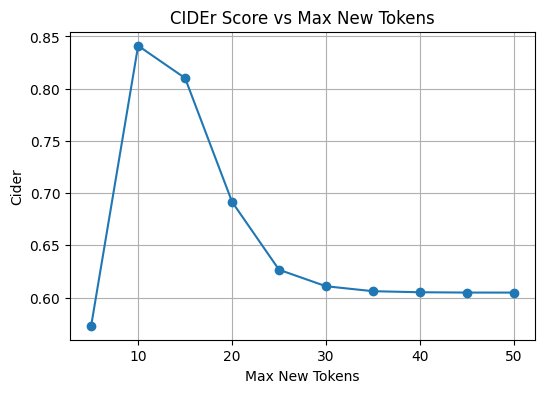

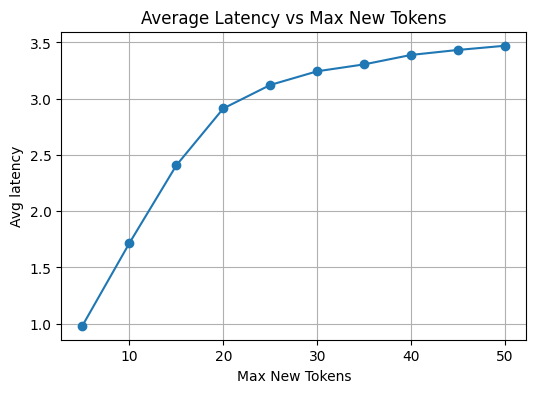

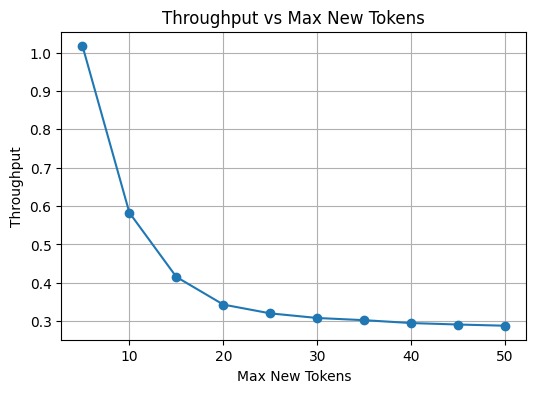

In [15]:
# --- After the loop finishes ---
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame for easier plotting
df = pd.DataFrame(results)

# Create separate plots for each metric
metrics = ["cider", "avg_latency", "throughput"]
titles = {
    "cider": "CIDEr Score vs Max New Tokens",
    "avg_latency": "Average Latency vs Max New Tokens",
    "throughput": "Throughput vs Max New Tokens"
}

for metric in metrics:
    plt.figure(figsize=(6,4))
    plt.plot(df["tokens"], df[metric], marker='o', linestyle='-')
    plt.title(titles[metric])
    plt.xlabel("Max New Tokens")
    plt.ylabel(metric.replace("_", " ").capitalize())
    plt.grid(True)
    plt.show()

## Step 9: Measuring Efficiency - peak VRAM (MiB) and model size on the disk

In [16]:

# --- More metrics: VRAM in MiB and model size on the disk

import os
import torch
import shutil

# Get peak VRAM usage
if torch.cuda.is_available():
    peak_vram_mib = torch.cuda.max_memory_allocated() / (1024**2)
    print(f"Peak VRAM usage: {peak_vram_mib:.2f} MiB")
else:
    print("CUDA is not available. Cannot measure VRAM usage.")

# Get disk usage of the current directory
total, used, free = shutil.disk_usage(".")
disk_usage_mib = used / (1024**2)
print(f"Disk usage: {disk_usage_mib:.2f} MiB") # approx 55GB

Peak VRAM usage: 7538.43 MiB
Disk usage: 55663.21 MiB


# Step 10: Qualitative Analysis
Running inference for 1 image and printing all inferred captions.

In [21]:
import time
import matplotlib.pyplot as plt

# Process only the first image
image_id, inputs = images_data[0]

token_counts = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
captions_per_token_count = {}

print(f"\n=== Qualitative Results from Weight-only INT8; {current_time} ===")


for token_count in token_counts:
    print(f"\n--- Evaluating for max_new_tokens = {token_count} ---")

    start_time = time.perf_counter()

    generate_ids = model.generate(**inputs, max_new_tokens=token_count)
    generated_text = processor.batch_decode(
        generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]

    end_time = time.perf_counter()
    latency = end_time - start_time

    caption = generated_text.split("ASSISTANT:")[-1].strip()
    captions_per_token_count[token_count] = caption

    generated_captions = {image_id: [caption]}

    cider_scorer = Cider()
    filtered_ground_truth_captions = {
        img_id: captions
        for img_id, captions in ground_truth_captions.items()
        if img_id in generated_captions
    }

    if token_count == 5:
      print(f"Ground truth captions: {filtered_ground_truth_captions}")

    cider_score, _ = cider_scorer.compute_score(filtered_ground_truth_captions, generated_captions)

    print(f"Latency: {latency:.3f} seconds")
    # print(f"CIDEr score: {cider_score:.3f}") NOT APPLICABLE - cannot be calculated for one image
    print(f"Generated caption: {caption}")


# --- Print all captions per token size ---
print("\n=== Captions for each token count ===")
for token_count, caption in captions_per_token_count.items():
    print(f"[{token_count} tokens]: {caption}")


=== Qualitative Results from Weight-only INT8; November 11, 13:58 ===

--- Evaluating for max_new_tokens = 5 ---
Ground truth captions: {139: ['A woman stands in the dining area at the table.', 'A room with chairs, a table, and a woman in it.', 'A woman standing in a kitchen by a window', 'A person standing at a table in a room.', 'A living area with a television and a table']}
Latency: 0.967 seconds
Generated caption: A woman is sitting at

--- Evaluating for max_new_tokens = 10 ---
Latency: 1.732 seconds
Generated caption: A woman is sitting at a dining table in

--- Evaluating for max_new_tokens = 15 ---
Latency: 2.495 seconds
Generated caption: A woman is sitting at a dining table in a kitchen, with a

--- Evaluating for max_new_tokens = 20 ---
Latency: 3.186 seconds
Generated caption: A woman is sitting at a dining table in a kitchen, with a potted plant nearby.

--- Evaluating for max_new_tokens = 25 ---
Latency: 3.948 seconds
Generated caption: A woman is sitting at a dining ta